# Quickstart Guide

This guide will give a quick intro to training PyTorch models with torchbearer. We'll start by loading in some data and defining a model, then we'll train it for a few epochs and see how well it does.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 



In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.3.2


## Loading Data

First, we load some data (CIFAR-10) in the usual way with `torchvision`. The `DatasetValidationSplitter` here lets us get a validation set to work with.

In [2]:
import torch
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)


testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


### Visualising the Data

We might want to see what our data looks like during the test pass of the model. With torchbearers [`MakeGrid`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.MakeGrid), from the [`imaging` sub-package](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#imaging) we can do this easily. **Note** that we use an inverse normalisation here to make the images visible.

In [3]:
import torchbearer
from torchbearer.callbacks import imaging

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

make_grid = imaging.MakeGrid(torchbearer.INPUT, num_images=64, nrow=8, transform=inv_normalize)
make_grid = make_grid.on_test().to_pyplot().to_file('sample.png')

In the above code, we construct a [`Callback`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.bases.Callback) that can later be used in a trial. **Note** the use of `torchbearer.INPUT`. In torchbearer, key variables relating to the training process are stored in a state dictionary using [`StateKey`](https://torchbearer.readthedocs.io/en/latest/code/main.html?highlight=statekey#torchbearer.state.StateKey) objects. The default state keys can be accessed through `torchbearer.XXX` and are listed [here](https://torchbearer.readthedocs.io/en/latest/code/main.html?highlight=statekey#key-list). In this case, we use `INPUT` to tell the callback that it should get the images from the input batch. The other methods we call (`on_test`, `to_pyplot`, etc.) are defined in the [`ImagingCallback` class](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.ImagingCallback). 

## Defining the Model

We now need a model, here's a simple 3 layer strided CNN:

In [4]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(576, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 576)
        return self.classifier(x)


model = SimpleModel()

Training on Cifar10
-------------------------------------

Typically we would need a training loop and a series of calls to backward, step etc.
Instead, with torchbearer, we can define our optimiser and some metrics (just 'acc' and 'loss' for now) and let it do the work. The main part of torchbearer that enables this is the [`Trial class`](https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.trial.Trial) which contains the core training methods. **Note**: We set `verbose=1` here to mean that the progress bar should only tick for each epoch (rather than each batch, we creates a lot of output), this can be set at a trial level or for each call to `run` or `evaluate`.

In [5]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

import torchbearer
from torchbearer import Trial

# If you have tensorboardX installed then write to tensorboard, else don't
import sys
if 'tensorboardX' in sys.modules:
  import tensorboardX
  from torchbearer.callbacks import TensorBoard
  callbacks = [TensorBoard(write_batch_metrics=True)]
else:
  callbacks = []

callbacks.append(make_grid)

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history = trial.run(epochs=5, verbose=1)

Now that our model is trained, let's evaluate it, triggering our callback from earlier. Here, we again use one of torchbearers state_keys to tell it to evaluate on the (unseen) test data.

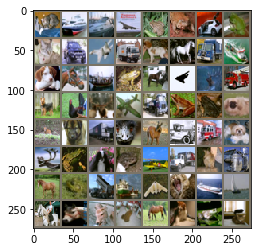

{'test_acc': 0.6567999720573425, 'test_loss': 0.9761508107185364}

In [6]:
trial.evaluate(data_key=torchbearer.TEST_DATA)

We can also get access to the training history of the trial (returned by the run method), if we wanted to do any post analysis. The history is a list with one entry for each epoch. Each entry contains a tuple (num_train_steps, num_val_steps) and the metric dictionary from that epoch.

In [7]:
print(history)

[((352, 40), {'running_acc': 0.5356249809265137, 'running_loss': 1.311218023300171, 'acc': 0.44946667551994324, 'loss': 1.5274814367294312, 'val_acc': 0.5389999747276306, 'val_loss': 1.2900903224945068}), ((352, 40), {'running_acc': 0.5998437404632568, 'running_loss': 1.136667251586914, 'acc': 0.5794888734817505, 'loss': 1.1804065704345703, 'val_acc': 0.6043999791145325, 'val_loss': 1.1251872777938843}), ((352, 40), {'running_acc': 0.63671875, 'running_loss': 1.0439308881759644, 'acc': 0.630311131477356, 'loss': 1.0476974248886108, 'val_acc': 0.6241999864578247, 'val_loss': 1.0394434928894043}), ((352, 40), {'running_acc': 0.6657812595367432, 'running_loss': 0.9543967247009277, 'acc': 0.6608889102935791, 'loss': 0.9619852900505066, 'val_acc': 0.6581999659538269, 'val_loss': 0.9835954904556274}), ((352, 40), {'running_acc': 0.6818749904632568, 'running_loss': 0.9066686034202576, 'acc': 0.6882666945457458, 'loss': 0.8895869851112366, 'val_acc': 0.6611999869346619, 'val_loss': 0.964340031